# Stationarity

A time series is stationary when mean, variance, covariance do not change over time. Stationarity is important because many models require a stationary time series where time series in the real world is hardly ever stationary.

## Setup

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm                                                                                                                          
import statsmodels.formula.api as smf                                                                                                                 
import statsmodels.tsa.api as smt
import random

%matplotlib inline

/Users/michaelbeale/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Generate a stationary data set

The following code will generate a stationary by creating what is referred to as a random walk. 

In [3]:
stationary_x = [x for x in range(100)]
#stationary_y = [0.05*np.random.normal() for j in range(len(stationary_x))]

stationary_y = np.random.normal(0, 1, 100)



## Mean doesn't change over time

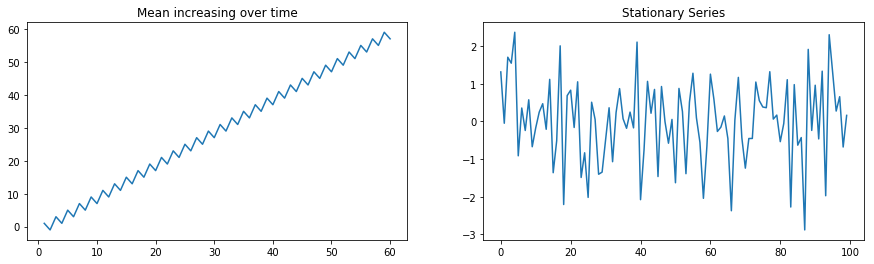

In [5]:
x, y = [], []
for i in range(1,60, 2):
    x += [i, i+1]
    y += [i, i - 2]

fig, axs = plt.subplots(1,2)
fig.set_size_inches(15, 4)

axs[0].set_title("Mean increasing over time")

axs[0].plot(x,y)
axs[1].set_title("Stationary Series")

axs[1].plot(stationary_x,stationary_y)

## Variance doesn't change over time

This property is known as homoscedasticity.  From wikipedia:

```In statistics, a sequence or a vector of random variables is homoscedastic if all random variables in the sequence or vector have the same finite variance```

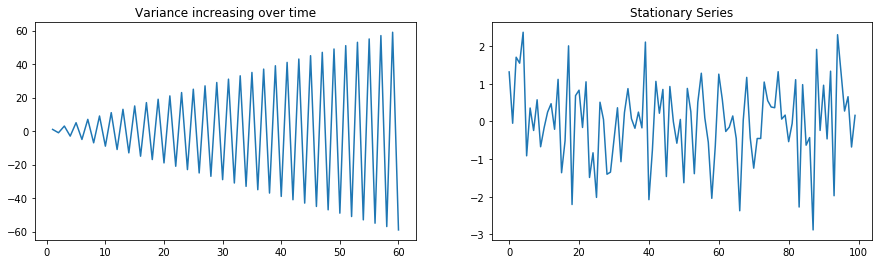

In [6]:
x, y = [], []
for i in range(1,60, 2):
    x += [i, i+1]
    y += [i, i - (i * 2)]
    
fig, axs = plt.subplots(1,2)
fig.set_size_inches(15, 4)

axs[0].set_title("Variance increasing over time")

axs[0].plot(x,y)
axs[1].set_title("Stationary Series")

axs[1].plot(stationary_x,stationary_y)

## Covariance doesn't change over time

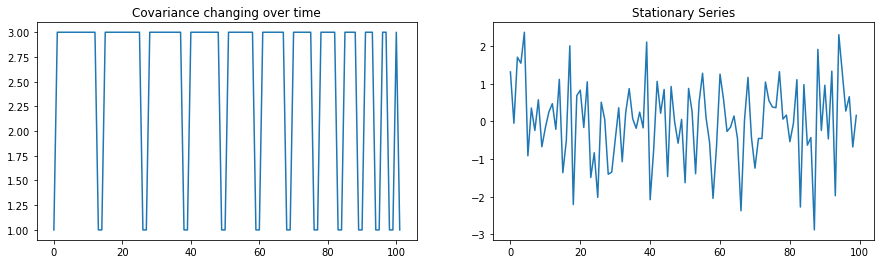

In [7]:
x, y = [x for x in range(102)], []

for i in range(12):
    y += [1] + [3 for x in range(12-i)] + [1]
fig, axs = plt.subplots(1,2)
fig.set_size_inches(15, 4)

axs[0].set_title("Covariance changing over time")

axs[0].plot(x,y)
axs[1].set_title("Stationary Series")

axs[1].plot(stationary_x,stationary_y)

## Checking for stationarity

### Augmented Dickey Fuller test

There will be a window and maxlag of 12 because this is seasonal monthly data making 12(or 1 year) an appropriate length.  If this was weekly data, 52 might be more appropriate.  It depends on the sample size and any seasonality in the data.  This test gives you a probability not a certainty.

You may find that domain knowledge of the data needs to be known in order to select appropriate parameters.  Alist of all possibilites for the ADF test are [here](http://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html).

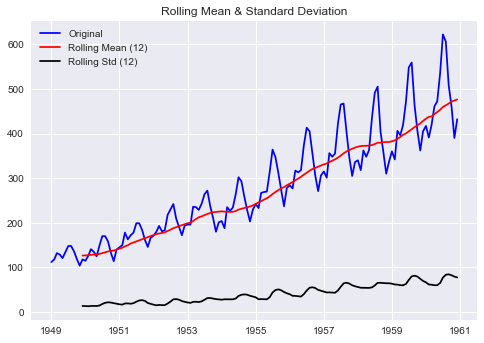

Test Statistic                   1.564685
p-value                          0.997748
#Lags Used                      12.000000
Number of Observations Used    131.000000
Critical Value (1%)             -3.481282
Critical Value (5%)             -2.883868
Critical Value (10%)            -2.578677
dtype: float64

In [4]:
from helpers.time_series import test_stationarity 
air = pd.read_csv('data/international-airline-passengers.csv', header=0, index_col=0, parse_dates=[0])
#Perform Augmented Dickey-Fuller test:                                                                                                                                                                         
test_stationarity(air['n_pass_thousands'], plot=True, maxlag=12, window=12)


Even without looking at the numbers, you can see that the mean is constantly changing as well as the variance.  A breakdown of the numbers here:

*  Test Statistic :  The more negative this number, the more likely we are to to conclude this data as non-stationary.
*  p-value        :  A p-value of <= 0.05 would indicate a stationary set of data
*  Critical Values:  The test statistic needs to be smaller then the %1 critical value.  If it is, you can say that the test has a 99% confidence interval that the data is stationary.

#### KPSS test

It's good to start with the ADF and use the KPSS test as a confirmation that the data is stationary by using the KPSS test.

Coming soon....http://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.kpss.html

### Transforming to stationary

#### Log Transformation - good for removing variance

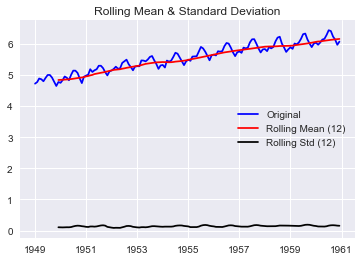

Test Statistic                  -1.951978
p-value                          0.308018
#Lags Used                      12.000000
Number of Observations Used    131.000000
Critical Value (1%)             -3.481282
Critical Value (5%)             -2.883868
Critical Value (10%)            -2.578677
dtype: float64

In [11]:
ts_log = np.log(air['n_pass_thousands'])
test_stationarity(ts_log, plot=True, maxlag=12, window=12)


In this case the rolling mean is still trending upwords.

#### First Difference

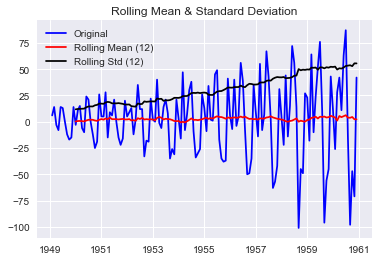

Test Statistic                  -2.829267
p-value                          0.054213
#Lags Used                      12.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64

In [12]:
air['first_difference'] = air['n_pass_thousands'] -  air['n_pass_thousands'].shift(1)
#dropna because of the shift
test_stationarity(air['first_difference'].dropna(), plot=True, window=12, maxlag=12)

It appears the rolling mean has stabilized around 0 but but the variance is increasing as time moves forward.

#### Seasonal Difference

There is more information on seasonality, but taking the difference of the seasonal periods could help make the data stationary.  In the case of the airline data, there is a monthly seasonality.

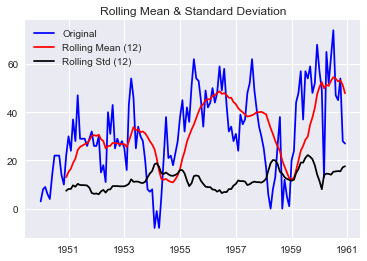

Test Statistic                  -2.425356
p-value                          0.134707
#Lags Used                      12.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64

In [13]:
air['seasonal_difference'] = air['n_pass_thousands'] -  air['n_pass_thousands'].shift(12)
#dropna because of the shift
test_stationarity(air['seasonal_difference'].dropna(), window=12, plot=True, maxlag=12)

This still didn't help make the data stationary.  We could try to take the seasonal difference of the first difference.

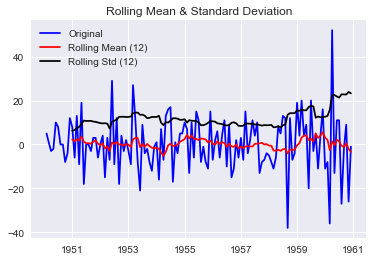

Test Statistic                  -3.800869
p-value                          0.002898
#Lags Used                       8.000000
Number of Observations Used    122.000000
Critical Value (1%)             -3.485122
Critical Value (5%)             -2.885538
Critical Value (10%)            -2.579569
dtype: float64

In [14]:
air['seasonal_first_difference'] = air['first_difference'] -  air['first_difference'].shift(12)
#dropna because of the shift
test_stationarity(air['seasonal_first_difference'].dropna(), window=12, plot=True, autolag='t-stat', maxlag=12)

This looks stationary because the p-value is < 0.05 and the test statistic is < 1% critical value.  We are 99% certain this is stationary.

#### Smoothing with log and moving average

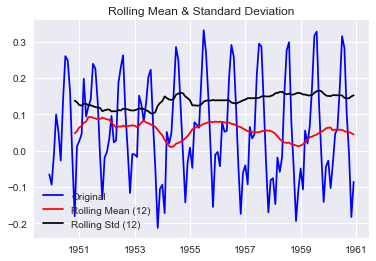

Test Statistic                  -2.235784
p-value                          0.193515
#Lags Used                      12.000000
Number of Observations Used    120.000000
Critical Value (1%)             -3.486056
Critical Value (5%)             -2.885943
Critical Value (10%)            -2.579785
dtype: float64

In [16]:
ts_log = np.log(air['n_pass_thousands'])
moving_avg = ts_log.rolling(window=12).mean() #use 12 for seasonality


#difference
ts_log_moving_avg_diff = ts_log - moving_avg

ts_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(ts_log_moving_avg_diff, window=12, plot=True, maxlag=12)

#### Exponentionaly weighted moving average

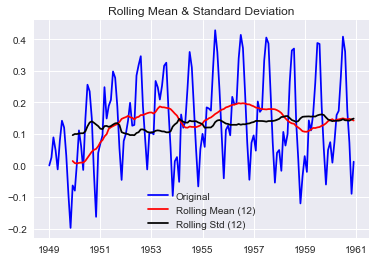

Test Statistic                  -3.496602
p-value                          0.008075
#Lags Used                      12.000000
Number of Observations Used    131.000000
Critical Value (1%)             -3.481282
Critical Value (5%)             -2.883868
Critical Value (10%)            -2.578677
dtype: float64

In [17]:
expwighted_avg = ts_log.ewm(halflife=12).mean()

ts_log_ewma_diff = ts_log - expwighted_avg
test_stationarity(ts_log_ewma_diff, plot=True, window=12, maxlag=12)

#### Decomposition

We go over decomposition and how to use is in another [notebook]('Decomposition.ipynb').

#### loess method (locally wieghted scatterplot smoothing)